In [1]:

import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from wrapper import utils
import seaborn as sns
from torchinfo import summary
import sys
from model import ConfigurableModel
import logomaker
import gc
from captum.attr import IntegratedGradients
from tangermeme.ism import saturation_mutagenesis
from tqdm import tqdm
# config = {"cnn_first_filter":16, "cnn_first_kernel_size":9, "cnn_length":3, "cnn_filter":32, "cnn_kernel_size":7, "bilstm_layer":3, "bilstm_hidden_size":128, "fc_size":64}
# model = ConfigurableModelWoBatchNorm(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
#                                 cnn_length=config["cnn_length"], cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
#                                 output_size=1)


fixed_tune_config = {'lr': 0.001, 'weight_decay': 0.1, 'cnn_first_filter': 24, 'cnn_first_kernel_size': 7, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 256, 'fc_size': 256}    
model = ConfigurableModel(input_channel=4, input_size=1001, cnn_first_filter=fixed_tune_config["cnn_first_filter"], cnn_first_kernel_size=fixed_tune_config["cnn_first_kernel_size"],
                                            cnn_other_filter=fixed_tune_config["cnn_filter"], cnn_other_kernel_size=fixed_tune_config["cnn_kernel_size"], bilstm_layer=fixed_tune_config["bilstm_layer"], bilstm_hidden_size=fixed_tune_config["bilstm_hidden_size"], fc_size=fixed_tune_config["fc_size"], output_size=2)
#fold
fold = 1
model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.pkl",
                            map_location=torch.device('cpu'))
model.load_state_dict(model_weight)
model.eval()

for k, v in model_weight.items():
    print(k)
meta_data_test_json_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/test_meta_data_SPLIT_{fold}.json"
seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNN.CNN_1.weight
CNN.CNN_1.bias
CNN.BATCHNORM_1.weight
CNN.BATCHNORM_1.bias
CNN.BATCHNORM_1.running_mean
CNN.BATCHNORM_1.running_var
CNN.BATCHNORM_1.num_batches_tracked
CNN.CNN_2.weight
CNN.CNN_2.bias
CNN.BATCHNORM_2.weight
CNN.BATCHNORM_2.bias
CNN.BATCHNORM_2.running_mean
CNN.BATCHNORM_2.running_var
CNN.BATCHNORM_2.num_batches_tracked
CNN.CNN_3.weight
CNN.CNN_3.bias
CNN.BATCHNORM_3.weight
CNN.BATCHNORM_3.bias
CNN.BATCHNORM_3.running_mean
CNN.BATCHNORM_3.running_var
CNN.BATCHNORM_3.num_batches_tracked
biLSTM.weight_ih_l0
biLSTM.weight_hh_l0
biLSTM.bias_ih_l0
biLSTM.bias_hh_l0
biLSTM.weight_ih_l0_reverse
biLSTM.weight_hh_l0_reverse
biLSTM.bias_ih_l0_reverse
biLSTM.bias_hh_l0_reverse
biLSTM.weight_ih_l1
biLSTM.weight_hh_l1
biLSTM.bias_ih_l1
biLSTM.bias_hh_l1
biLSTM.weight_ih_l1_reverse
biLSTM.weight_hh_l1_reverse
biLSTM.bias_ih_l1_reverse
biLSTM.bias_hh_l1_reverse
biLSTM.weight_ih_l2
biLSTM.weight_hh_l2
biLSTM.bias_ih_l2
biLSTM.bias_hh_l2
biLSTM.weight_ih_l2_reverse
biLSTM.weight_hh_l2_r

In [2]:
# Load the validation results to get only the top 1000 sequences with lowest average MSE (mean of control and case error) 

valid_data = pd.read_csv(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2
valid_data.head()

# Select the top 2000 sequences with lowest average MSE
selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]

In [ ]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = deep_lift_shap(model, seq_fasta_one_hot[list(selected_sequences),:,:], target=0, random_state=0)
# Element-wise multiplication with sequence, averaging to ge the plot 
plot_matrix2 = np.average(X_attr, axis=0)
df2 = pd.DataFrame(plot_matrix2.T, columns=list("ACGU"))

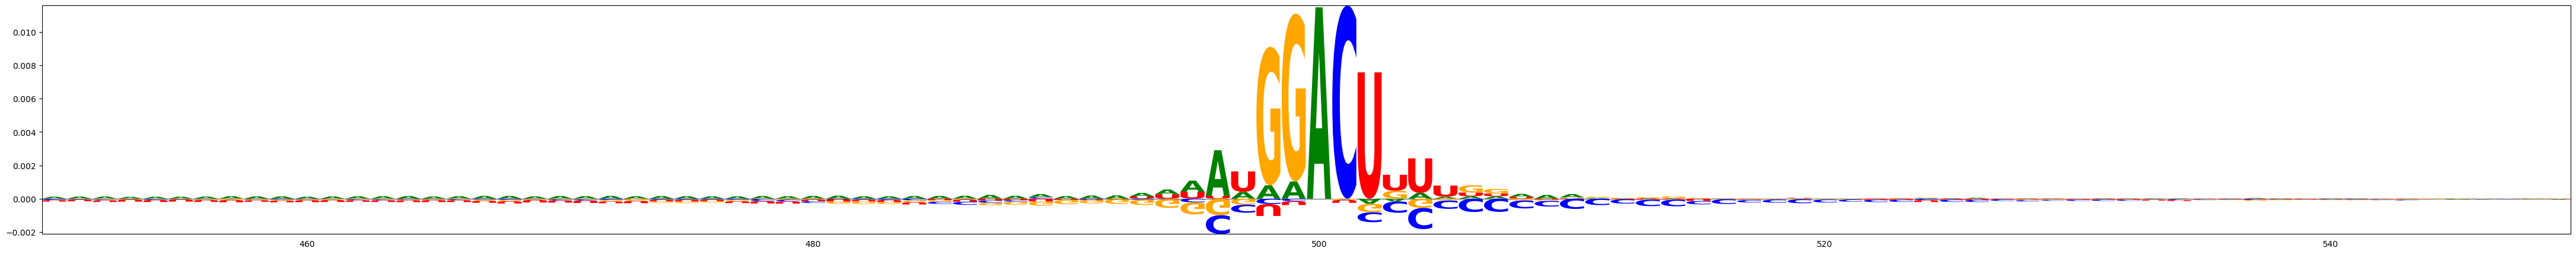

In [76]:
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo(df2.iloc[450:550,], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()

<Axes: >

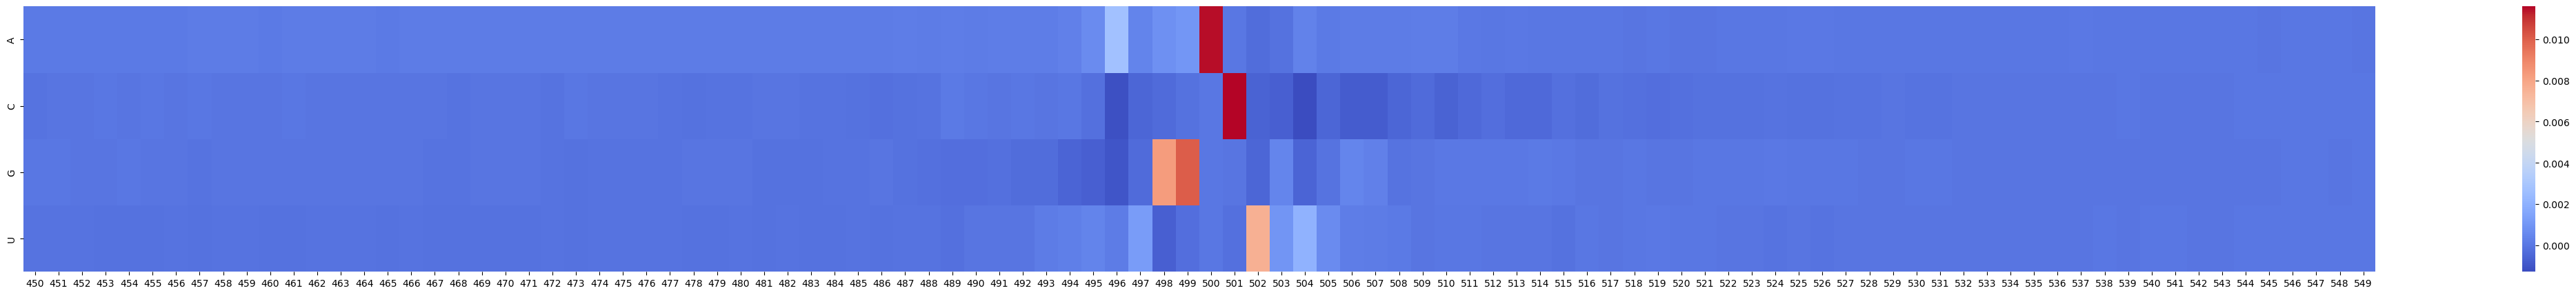

In [62]:
fig, ax = plt.subplots(figsize=(55, 5))
sns.heatmap((df2.T).iloc[:,450:550], cmap="coolwarm")

# ISM (Insilico Saturation Mutagenesis)

### Normal condition (target = 0)

In [170]:
# For 2k sequences it takes ~135 minutes to run
X_attr_ism_normal = saturation_mutagenesis(model, seq_fasta_one_hot[list(selected_sequences),:,:], target=0)
plot_matrix_ism_normal = np.average(X_attr_ism_normal, axis=0)
df_ism_normal = pd.DataFrame(plot_matrix_ism_normal.T, columns=list("ACGU"))

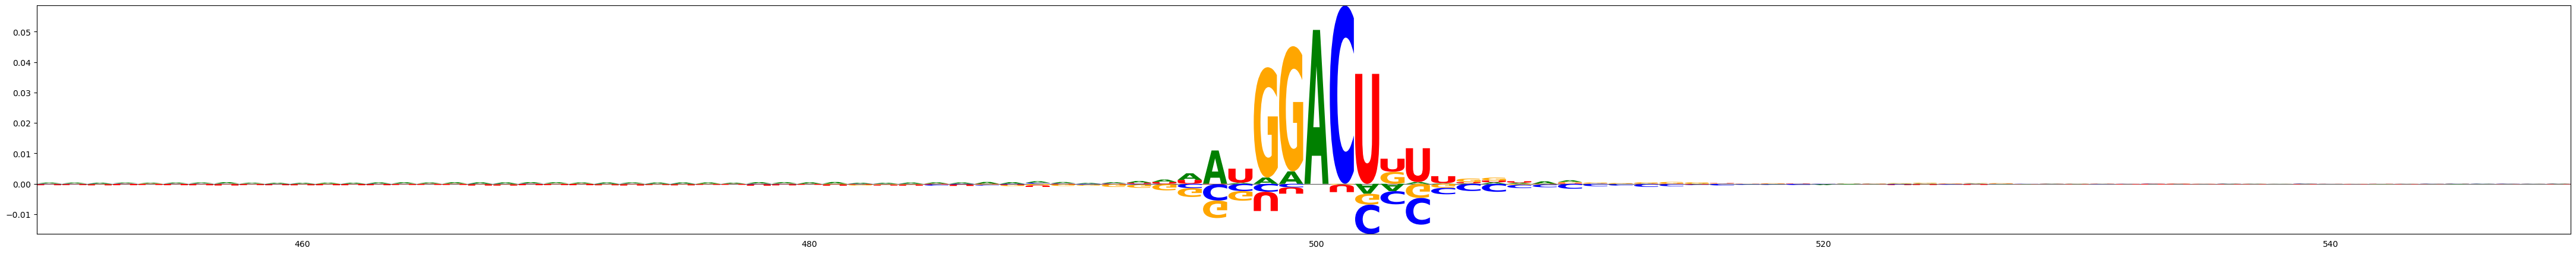

In [171]:
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo(df_ism_normal.iloc[450:550], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()

<Axes: >

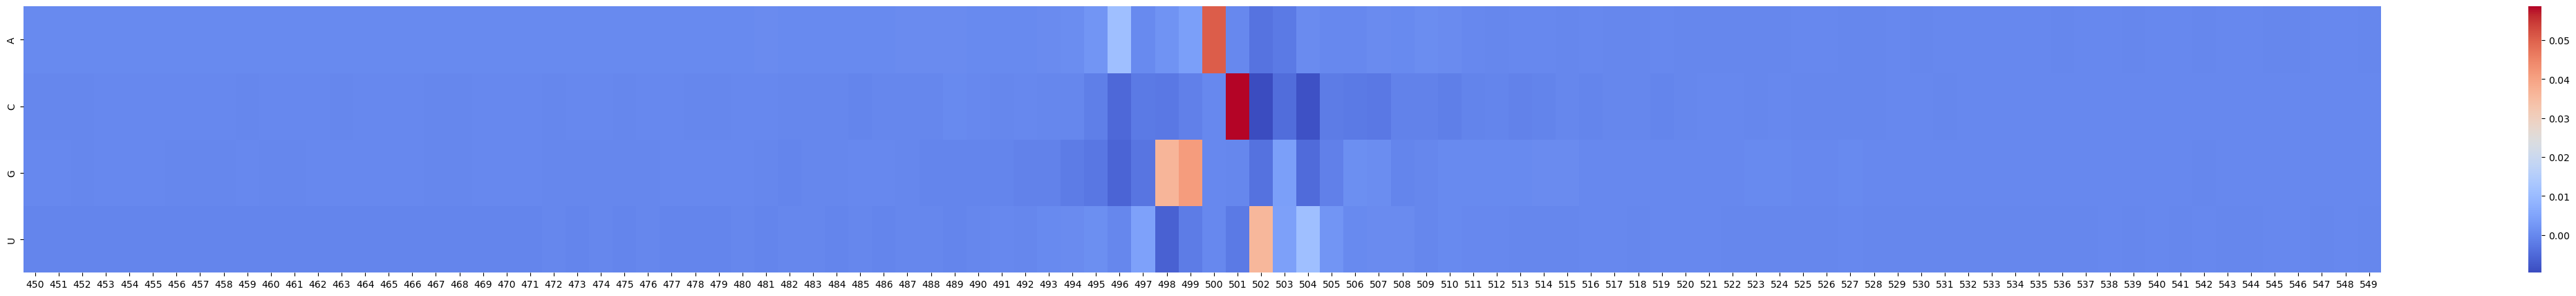

In [172]:
fig, ax = plt.subplots(figsize=(55, 5))
sns.heatmap((df_ism_normal.T).iloc[:,450:550], cmap="coolwarm")

Notes: The above plot logo and map contain the "attribution score" which not the raw delta score. The attribution socre is the delta of score subtracted with the mean score for the position. To get the raw delta you need to get the raw=True in the argument.

### Hypoxia condition (target = 1)

In [173]:
X_attr_ism_hypox = saturation_mutagenesis(model, seq_fasta_one_hot[list(selected_sequences),:,:], target=1)
plot_matrix_ism_hypox = np.average(X_attr_ism_hypox, axis=0)
df_ism_hypox = pd.DataFrame(plot_matrix_ism_hypox.T, columns=list("ACGU"))

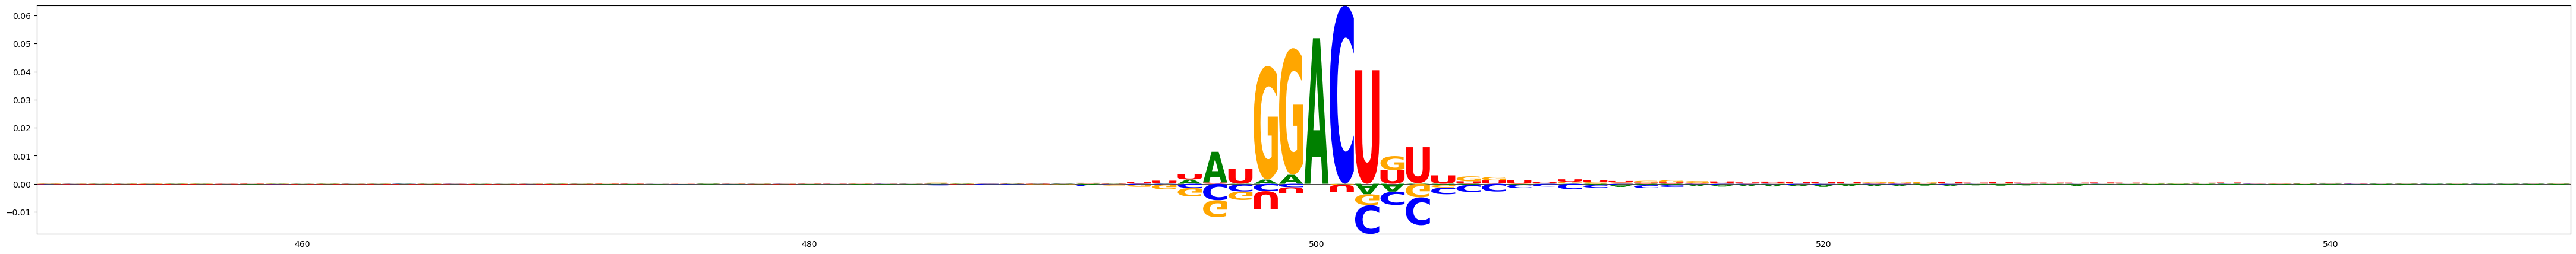

In [177]:
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo(df_ism_hypox.iloc[450:550], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()

<Axes: >

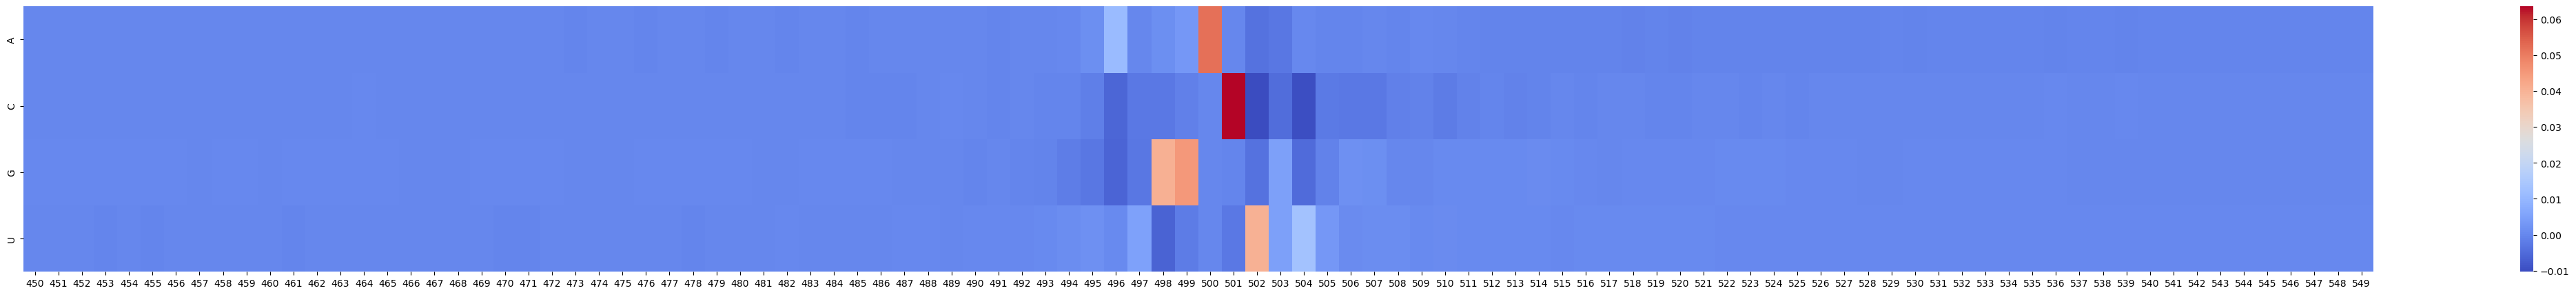

In [178]:
fig, ax = plt.subplots(figsize=(55, 5))
sns.heatmap((df_ism_hypox.T).iloc[:,450:550], cmap="coolwarm")

Notes: The above plot logo and map contain the "attribution score" which not the raw delta score. The attribution socre is the delta of score subtracted with the mean score for the position. To get the raw delta you need to get the raw=True in the argument.

## Raw results for plotting the scatter

In [181]:
y_ref, y_ism = saturation_mutagenesis(model, seq_fasta_one_hot[list(selected_sequences),:,:], raw_outputs=True)

In [245]:
def attribution_score(y0, y_hat, target):
	"""ISM attributions calculation"""

	attr = y_hat[:, :, :, target] - y0[:, None, None, target]
	attr -= torch.mean(attr, dim=1, keepdims=True)

	if len(attr.shape) > 3:
		attr = torch.mean(attr, dim=tuple(range(3, len(attr.shape))))
	return attr

In [231]:
y_delta = y_ism - y_ref[:, None, None]
print("Saving...")
np.savez(f"ism/ism_raw_fold_{fold}_fixed_tune.npz", y_delta=y_delta, y_ism=y_ism, y_ref=y_ref)
print("Saving Done")

Saving...


Saving Done


In [329]:
coba = np.load(f"ism/ism_raw_fold_{fold}_fixed_tune.npz")
coba["y_delta"].shape

(2000, 4, 1001, 2)

### Normal condition (target = 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


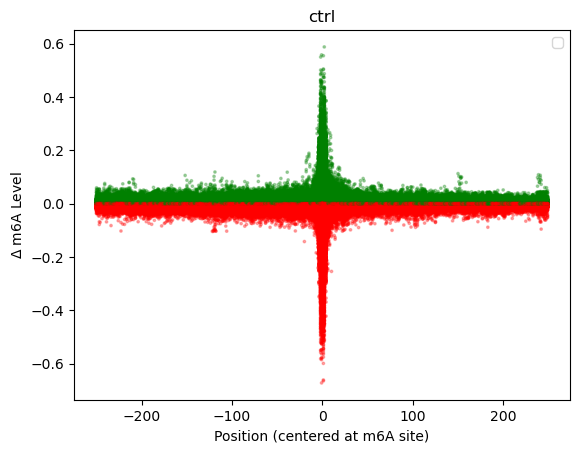

In [183]:
# Example data (replace this with your actual numpy array)
ctrl = y_delta[:,:,:,0]
ctrl = ctrl.reshape(-1,1001)
data = ctrl[:,250:750].numpy()
mutation_size = 500
# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('ctrl')
ax.legend()

# Show the plot
plt.show()

[Text(0.5, 13.249999999999995, 'Nucleotide Position Centered at m6A Site')]

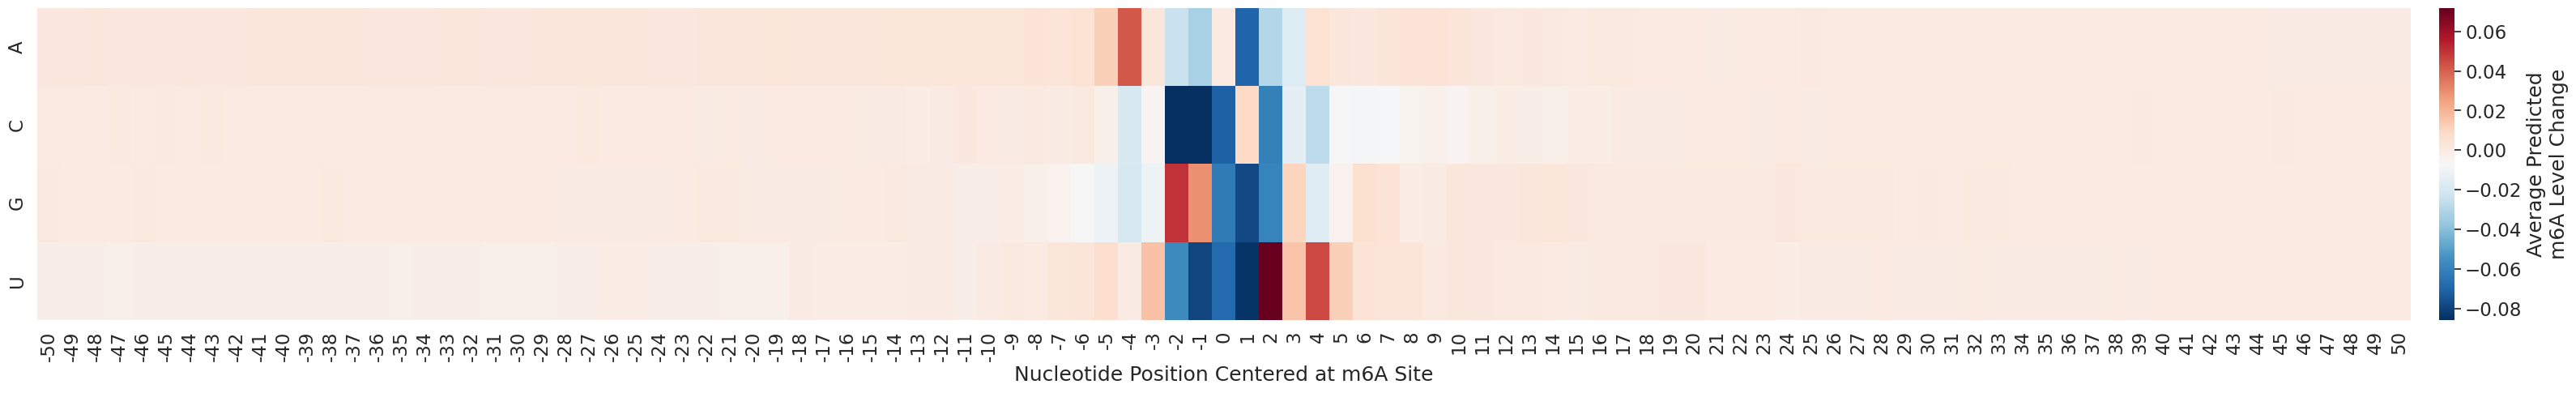

In [252]:
y_delta[:,:,:,0].shape
slice_start = 450
slice_end = 551
plot_df = pd.DataFrame(torch.mean(y_delta[:,:,:,0], dim=0).numpy().T, columns=list("ACGU"))

fig, ax = plt.subplots(figsize=(45, 5))

sns.set(font_scale=1.5, style='white')
s = sns.heatmap(data=(plot_df.T).iloc[:,slice_start:slice_end], xticklabels=list(range(slice_start-500,slice_end-500)), cmap="RdBu_r", cbar_kws={"pad": 0.01, "label":"Average Predicted\nm6A Level Change"})
s.set(xlabel='Nucleotide Position Centered at m6A Site')


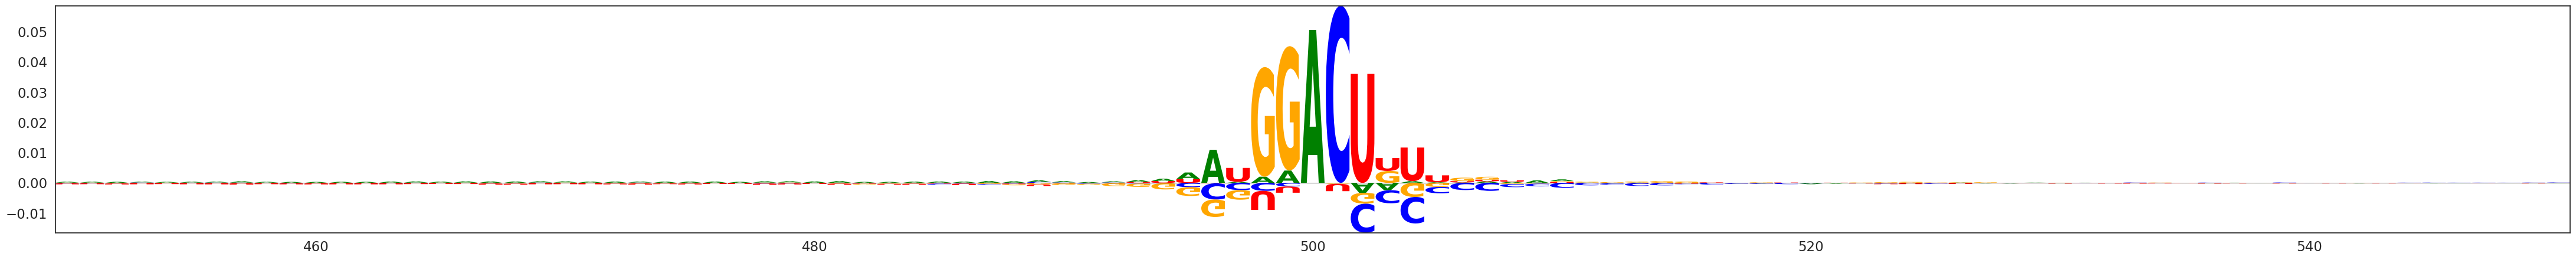

<Figure size 640x480 with 0 Axes>

In [256]:
attr = attribution_score(y_ref, y_ism, 0)
attr = attr * seq_fasta_one_hot[list(selected_sequences),:,:]
plot_logo = np.average(attr, axis=0)
plot_logo_df = pd.DataFrame(plot_logo.T, columns=list("ACGU"))
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo((plot_logo_df).iloc[slice_start:slice_end], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
plt.show()
plt.savefig(f"ism/normal_logo_ism_fold_{fold}.png")


### Hypoxia condition (target=1):

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


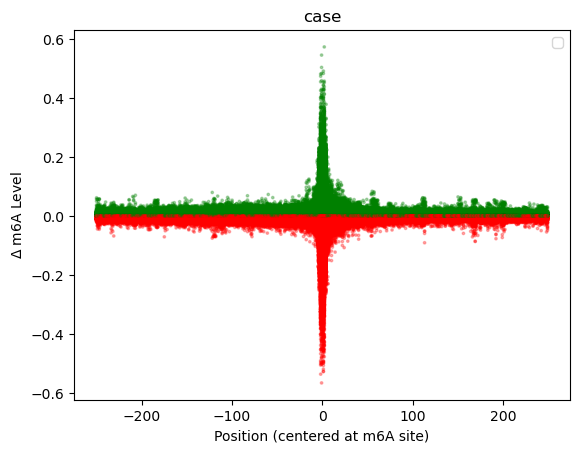

In [184]:
# Example data (replace this with your actual numpy array)
case = y_delta[:,:,:,1]
case = case.reshape(-1,1001)
data = case[:,250:750].numpy()
mutation_size = 500
# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('case')
ax.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(36, 101)
(101,)


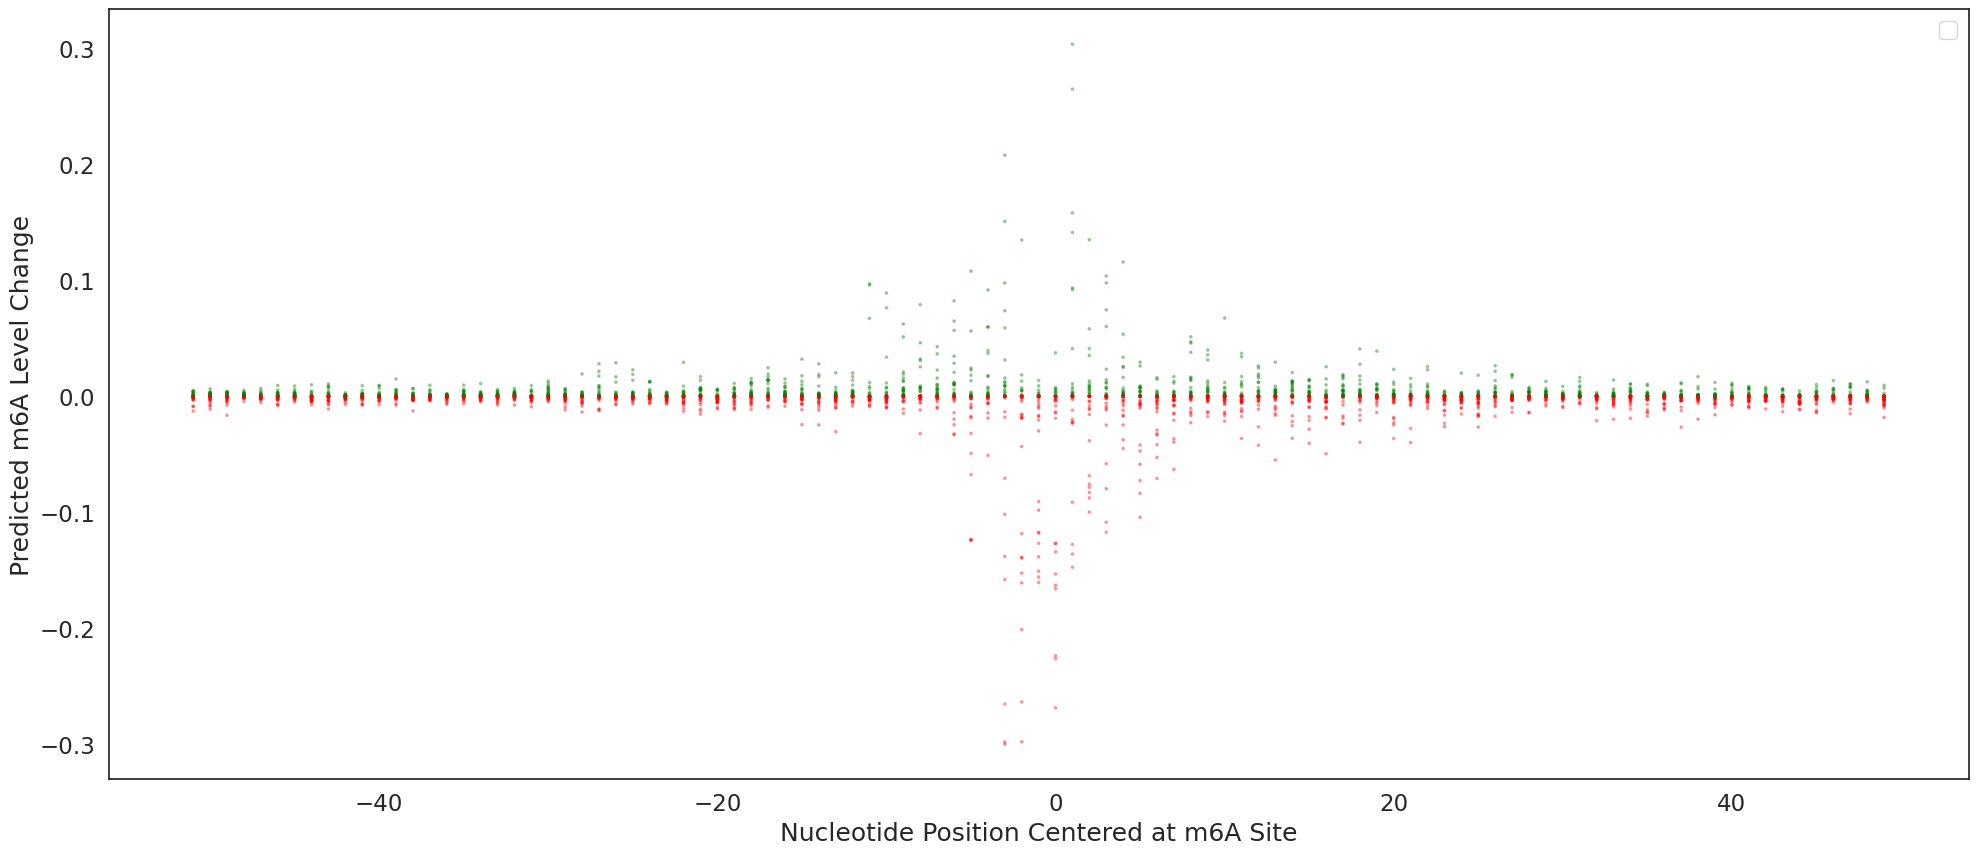

In [327]:
plot_ism_scatter(y_delta[1:10,:,:,:], 1, slice_start = 450, slice_end = 551)

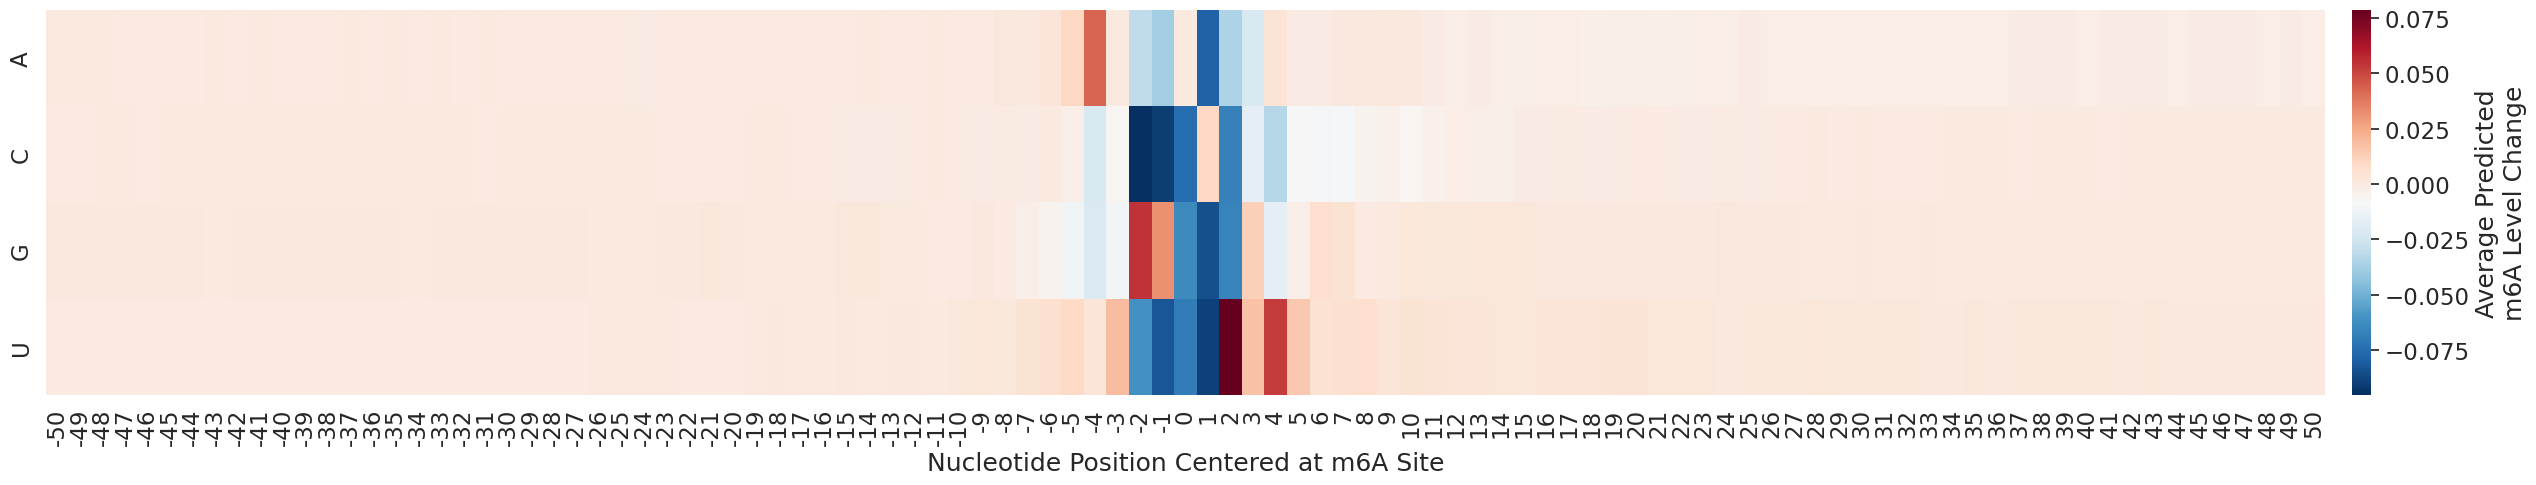

In [280]:
y_delta[:,:,:,1].shape
slice_start = 450
slice_end = 551
plot_df = pd.DataFrame(torch.mean(y_delta[:,:,:,1], dim=0).numpy().T, columns=list("ACGU"))

fig, ax = plt.subplots(figsize=(35, 5))

sns.set(font_scale=1.5)
s = sns.heatmap(data=(plot_df.T).iloc[:,slice_start:slice_end], xticklabels=list(range(slice_start-500,slice_end-500)), cmap="RdBu_r", cbar_kws={"pad": 0.01, "label":"Average Predicted\nm6A Level Change"})
s.set(xlabel='Nucleotide Position Centered at m6A Site')

plt.savefig(f"ism/hypox_avg_score_ism_fold_{fold}.png",bbox_inches='tight')

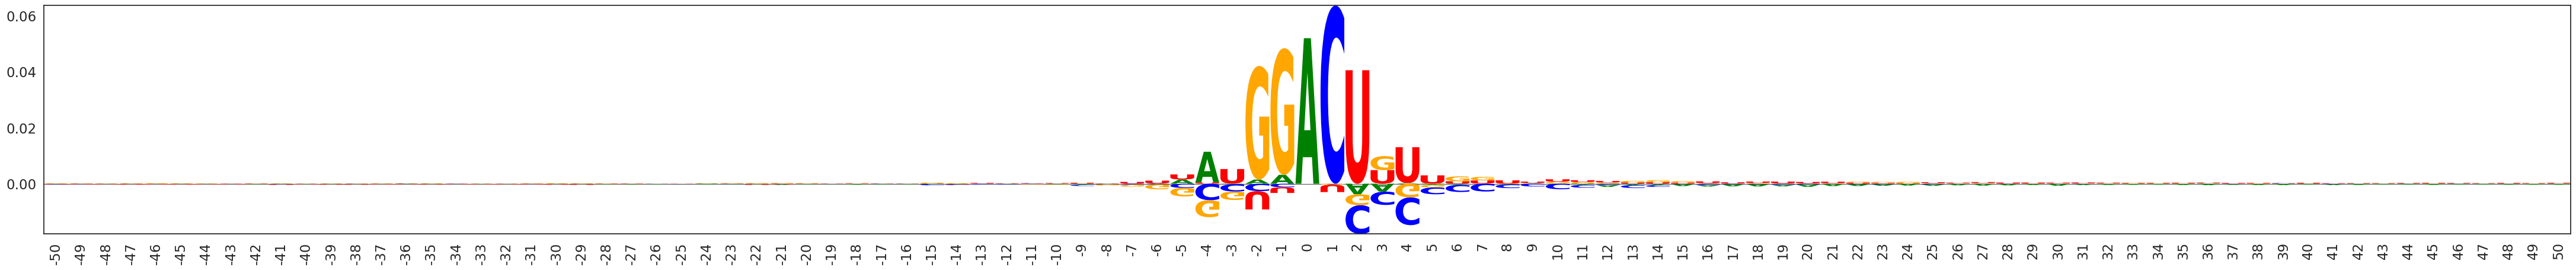

In [317]:
slice_start = 450
slice_end = 551
attr = attribution_score(y_ref, y_ism, 1)
attr = attr * seq_fasta_one_hot[list(selected_sequences),:,:]
plot_logo = np.average(attr, axis=0)
plot_logo_df = pd.DataFrame(plot_logo.T, columns=list("ACGU"))
fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo((plot_logo_df).iloc[slice_start:slice_end], ax=ax, color_scheme='classic')
ax.xaxis.set_ticks_position("none")
ax.set_facecolor("white")
plt.grid(False)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 16})
plt.xticks(list(range(slice_start, slice_end)), list(range(slice_start-500, slice_end-500)))  
plt.savefig(f"ism/hypox_logo_ism_fold_{fold}.png" ,bbox_inches='tight')
plt.show()

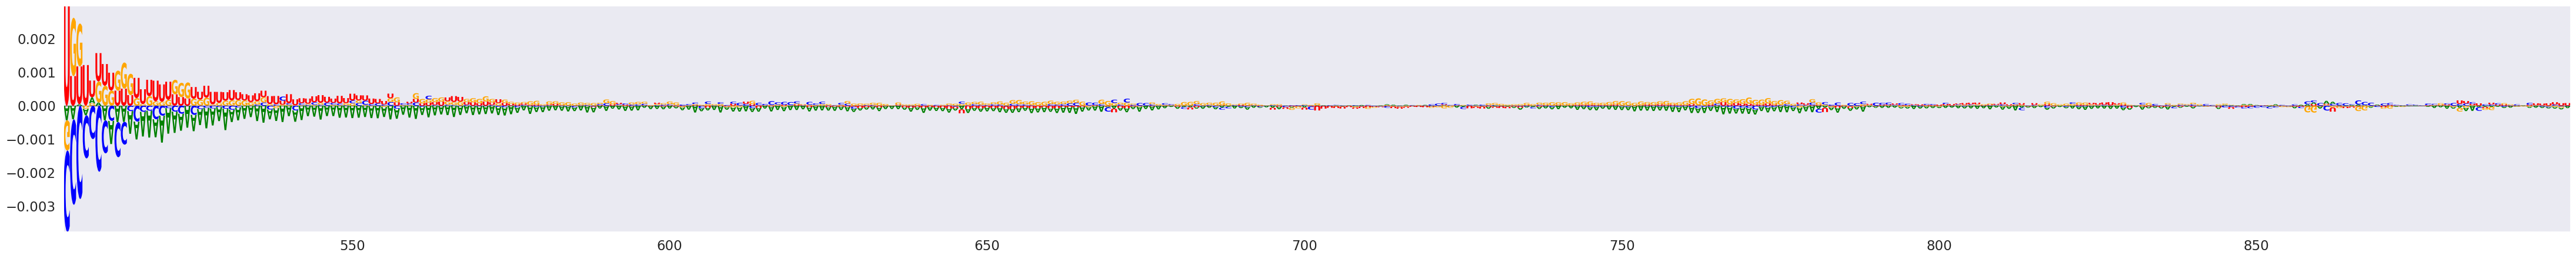

In [294]:

fig, ax = plt.subplots(figsize=(55, 5))
logomaker.Logo((plot_logo_df).iloc[505:900], ax=ax, color_scheme='classic')
plt.show()

In [331]:
def attribution_score(y0, y_hat, target):
	"""ISM attributions calculation"""

	attr = y_hat[:, :, :, target] - y0[:, None, None, target]
	attr -= torch.mean(attr, dim=1, keepdims=True)

	if len(attr.shape) > 3:
		attr = torch.mean(attr, dim=tuple(range(3, len(attr.shape))))
	return attr

def plot_ism_scatter(y_delta, target, slice_start = 250, slice_end = 751):
	# Example data (replace this with your actual numpy array)
	group = "hypoxia" if target==1 else "normal"
	data = y_delta[:,:,:,target]
	data = data.reshape(-1,1001)
	data = data[:,slice_start:slice_end].numpy()
	print(data.shape)
	# Generate x values: from -100 to 99

	mutation_size = slice_end - slice_start
	x = np.arange(-mutation_size//2, mutation_size//2)
	print(x.shape)
	# Plotting each row against xfig, ax = plt.subplots(figsize=(45, 5))
	fig, ax = plt.subplots(figsize=(24, 10))
	for i in range(data.shape[0]):
		# Determine colors for each point based on its sign
		colors = ['green' if value > 0 else 'red' for value in data[i]]
		
		# Scatter plot with conditional coloring
		ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

	# Adding labels and legend
	ax.set_xlabel('Nucleotide Position Centered at m6A Site')
	ax.set_ylabel('Predicted m6A Level Change')
	ax.legend()

	plt.rcParams.update({'font.size': 12})
	plt.savefig(f"ism/{group}_delta_m6A_fold_{fold}_{slice_start}_{slice_end}.png",bbox_inches='tight')
	# Show the plot
	plt.show()

def plot_score_heatmap(attr, target:int, fold:int, slice_start = 450, slice_end = 551):
	"""
	Calculate the mean of attribution i.e. difference score between ISM and reference or other desired score
	"""
	group = "hypoxia" if target==1 else "normal"
	slice_start = slice_start
	slice_end = slice_end
	plot_df = pd.DataFrame(torch.mean(attr[:,:,:,target], dim=0).numpy().T, columns=list("ACGU"))

	fig, ax = plt.subplots(figsize=(45, 5))

	sns.set(font_scale=1.5, style='white')
	s = sns.heatmap(data=(plot_df.T).iloc[:,slice_start:slice_end], xticklabels=list(range(slice_start-500,slice_end-500)), cmap="RdBu_r", cbar_kws={"pad": 0.01, "label":"Average Predicted\nm6A Level Change"})
	s.set(xlabel='Nucleotide Position Centered at m6A Site')
	plt.savefig(f"ism/{group}_avg_score_ism_fold_{fold}.png",bbox_inches='tight')
	plt.show()

def plot_logos(y_ref, y_ism, input_sequences, target:int, fold:int, slice_start = 450, slice_end = 551):
	group = "hypoxia" if target==1 else "normal"
	slice_start = slice_start
	slice_end = slice_end
	attr = attribution_score(y_ref, y_ism, target)
	# This is important to only show nucleotide which only appear on the input sequences i.e. m6A site only has "A"
	attr = attr * input_sequences
	plot_logo = np.average(attr, axis=0)
	plot_logo_df = pd.DataFrame(plot_logo.T, columns=list("ACGU"))
	fig, ax = plt.subplots(figsize=(55, 5))
	logomaker.Logo((plot_logo_df).iloc[slice_start:slice_end], ax=ax, color_scheme='classic')
	ax.xaxis.set_ticks_position("none")
	ax.set_facecolor("white")
	plt.xticks(rotation=90)
	plt.rcParams.update({'font.size': 16})
	plt.grid(False)
	plt.xticks(list(range(slice_start, slice_end)), list(range(slice_start-500, slice_end-500)))  
	plt.savefig(f"ism/{group}_logo_ism_fold_{fold}.png" ,bbox_inches='tight')
	plt.show()

def ism_analysis(model:torch.nn.Module, input_sequences:torch.Tensor, fold:int): 
    """
    Run ISM analysis given input sequences in one-hot encoded format
    """
    y_ref, y_ism = saturation_mutagenesis(model, input_sequences, raw_outputs=True)
    y_delta = y_ism - y_ref[:, None, None]
    print("Saving...")
    np.savez(f"ism/ism_raw_fold_{fold}_fixed_tune.npz", y_delta=y_delta, y_ism=y_ism, y_ref=y_ref)
    print("Saving Done")
	
    plot_score_heatmap(y_delta, 0, fold, slice_start = 450, slice_end = 551)
    plot_score_heatmap(y_delta, 1, fold, slice_start = 450, slice_end = 551)

    plot_logos(y_ref, y_ism, input_sequences, 0, fold, slice_start = 450, slice_end = 551)
    plot_logos(y_ref, y_ism, input_sequences, 1, fold, slice_start = 450, slice_end = 551)

    plot_score_heatmap(y_delta, 0, fold, slice_start = 250, slice_end = 751)
    plot_score_heatmap(y_delta, 1, fold, slice_start = 250, slice_end = 751)
    plot_score_heatmap(y_delta, 0, fold, slice_start = 450, slice_end = 551)
    plot_score_heatmap(y_delta, 1, fold, slice_start = 450, slice_end = 551)
    

In [340]:
PROJECT_PATH = "/binf-isilon/renniegrp/vpx267/ucph_thesis"
for fold in tqdm(range(2,6), desc=f"ISM Analysis"): 
    model_weight = torch.load(f"{PROJECT_PATH}/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.pkl",
                            map_location=torch.device('cpu'))
    model.load_state_dict(model_weight)
    model.eval()
    meta_data_test_json_path = f"{PROJECT_PATH}/data/dual_outputs/test_meta_data_SPLIT_{fold}.json"
    seq_fasta_test_path = f"{PROJECT_PATH}/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    valid_data = pd.read_csv(f"{PROJECT_PATH}/data/outputs/predictions/validation_{fold}th_fold_dual_outputs_m6A_info-no_promoter-False_fixed_tune.csv") 

    valid_data["avg_mse"] = ((valid_data["true_control"] - valid_data["pred_control"])**2 + (valid_data["true_case"] - valid_data["true_case"])**2)/2

    # Select the top 2000 sequences with lowest average MSE
    selected_sequences = np.argsort(valid_data["avg_mse"].values)[:2000]
    print("Starting ISM Analysis...")
    ism_analysis(model=model, input_sequences=seq_fasta_one_hot[list(selected_sequences),:,:], fold=fold)
    print("Finished ISM Analysis...")

ISM Analysis:   0%|          | 0/4 [00:00<?, ?it/s]

Starting ISM Analysis...
